# Binomial Option Pricing Model for TSLA Stock

This project implements the Binomial option pricing model for European and American options on TSLA stock, compares it with the Black-Scholes model, and analyzes parameter sensitivity and Greeks.


In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")



Bad key text.latex.preview in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default 

Libraries imported successfully!


## 1. Download and Save TSLA Stock Price Data


In [2]:
# Download 1-year TSLA stock price data
ticker = "TSLA"
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print(f"Downloading TSLA data from {start_date.date()} to {end_date.date()}...")
tsla_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Save to CSV
tsla_data.to_csv('TSLA_1year_data.csv')

tsla_data.head()



YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-12-12,418.100006,429.299988,415.000000,424.839996,87752200
2024-12-13,436.230011,436.299988,415.709991,420.000000,89000200
2024-12-16,463.019989,463.190002,436.149994,441.089996,114083800
2024-12-17,479.859985,483.989990,457.510010,475.899994,131223000
2024-12-18,440.130005,488.540009,427.010010,466.500000,149340800


Current TSLA stock price: $458.96
Annualized volatility: 0.6494 (64.94%)


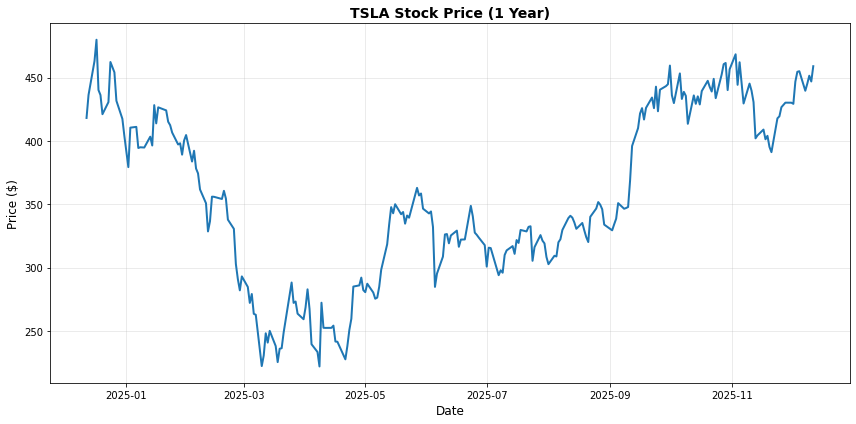

In [3]:
# Get current stock price and calculate volatility
current_price = float(tsla_data['Close'].iloc[-1])
print(f"Current TSLA stock price: ${current_price:.2f}")

# Calculate daily returns and annualized volatility
tsla_data['Returns'] = tsla_data['Close'].pct_change()
daily_volatility = tsla_data['Returns'].std()
annual_volatility = daily_volatility * np.sqrt(252)  # 252 trading days per year

print(f"Annualized volatility: {annual_volatility:.4f} ({annual_volatility*100:.2f}%)")

# Plot stock price over time
plt.figure(figsize=(12, 6))
plt.plot(tsla_data.index, tsla_data['Close'], linewidth=2)
plt.title('TSLA Stock Price (1 Year)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. Implement Binomial Option Pricing Model


In [4]:
class BinomialOptionPricer:
    """
    Binomial Option Pricing Model for European and American options
    """
    
    def __init__(self, S0, K, T, r, sigma, n_steps, option_type='call', exercise_type='european'):
        """
        Parameters:
        S0: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free interest rate
        sigma: Volatility (annualized)
        n_steps: Number of time steps in the binomial tree
        option_type: 'call' or 'put'
        exercise_type: 'european' or 'american'
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_steps = n_steps
        self.option_type = option_type.lower()
        self.exercise_type = exercise_type.lower()
        
        # Calculate tree parameters
        self.dt = T / n_steps
        self.u = np.exp(sigma * np.sqrt(self.dt))  # Up factor
        self.d = 1 / self.u  # Down factor
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability
        self.discount = np.exp(-r * self.dt)  # Discount factor
        
    def payoff(self, S):
        """Calculate option payoff at expiration"""
        if self.option_type == 'call':
            return max(S - self.K, 0)
        else:  # put
            return max(self.K - S, 0)
    
    def price(self):
        """Price the option using binomial tree"""
        # Initialize stock price tree
        stock_prices = np.zeros((self.n_steps + 1, self.n_steps + 1))
        
        # Build stock price tree
        for i in range(self.n_steps + 1):
            for j in range(i + 1):
                stock_prices[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        
        # Initialize option value tree
        option_values = np.zeros((self.n_steps + 1, self.n_steps + 1))
        
        # Calculate option values at expiration
        for j in range(self.n_steps + 1):
            option_values[j, self.n_steps] = self.payoff(stock_prices[j, self.n_steps])
        
        # Backward induction
        for i in range(self.n_steps - 1, -1, -1):
            for j in range(i + 1):
                # Expected value if holding
                hold_value = self.discount * (self.p * option_values[j, i + 1] + 
                                             (1 - self.p) * option_values[j + 1, i + 1])
                
                if self.exercise_type == 'american':
                    # For American options, check early exercise
                    exercise_value = self.payoff(stock_prices[j, i])
                    option_values[j, i] = max(hold_value, exercise_value)
                else:
                    # For European options, no early exercise
                    option_values[j, i] = hold_value
        
        return option_values[0, 0]
    
    def calculate_greeks(self, h=0.01, H=1):
        """
        Calculate Greeks using finite difference method
        h: perturbation size
        """
        # Delta: sensitivity to stock price
        pricer_up = BinomialOptionPricer(self.S0 * (1 + h), self.K, self.T, self.r, 
                                         self.sigma, self.n_steps, self.option_type, self.exercise_type)
        pricer_down = BinomialOptionPricer(self.S0 * (1 - h), self.K, self.T, self.r, 
                                           self.sigma, self.n_steps, self.option_type, self.exercise_type)
        delta = (pricer_up.price() - pricer_down.price()) / (2 * h * self.S0)
        
        # Gamma: second derivative with respect to stock price
        price_current = self.price()
        gamma = (pricer_up.price() - 2 * price_current + pricer_down.price()) / ((h * self.S0) ** 2)
        
        # Theta: sensitivity to time (negative of derivative w.r.t. time)
        pricer_theta = BinomialOptionPricer(self.S0, self.K, self.T - H/365, self.r, 
                                            self.sigma, self.n_steps, self.option_type, self.exercise_type)
        theta = -(pricer_theta.price() - price_current) / (H/365)
        
        # Vega: sensitivity to volatility
        pricer_vega = BinomialOptionPricer(self.S0, self.K, self.T, self.r, 
                                           self.sigma + h, self.n_steps, self.option_type, self.exercise_type)
        vega = (pricer_vega.price() - price_current) / h
        
        return {
            'Delta': delta,
            'Gamma': gamma,
            'Theta': theta,
            'Vega': vega
        }


## 3. Implement Black-Scholes Model


In [5]:
class BlackScholesPricer:
    """
    Black-Scholes Option Pricing Model
    """
    
    def __init__(self, S0, K, T, r, sigma, option_type='call'):
        """
        Parameters:
        S0: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free interest rate
        sigma: Volatility (annualized)
        option_type: 'call' or 'put'
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()
    
    def price(self):
        """Calculate Black-Scholes option price"""
        if self.T <= 0:
            # At expiration
            if self.option_type == 'call':
                return max(self.S0 - self.K, 0)
            else:
                return max(self.K - self.S0, 0)
        
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        
        if self.option_type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else:  # put
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        
        return price
    
    def calculate_greeks(self):
        """Calculate Black-Scholes Greeks"""
        if self.T <= 0:
            # At expiration, Greeks are not well-defined
            return {'Delta': 0, 'Gamma': 0, 'Theta': 0, 'Vega': 0}
        
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        
        # Delta
        if self.option_type == 'call':
            delta = norm.cdf(d1)
        else:  # put
            delta = -norm.cdf(-d1)
        
        # Gamma (same for call and put)
        gamma = norm.pdf(d1) / (self.S0 * self.sigma * np.sqrt(self.T))
        
        # Theta
        if self.option_type == 'call':
            theta = (-self.S0 * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T)) 
                    - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2)) / 365
        else:  # put
            theta = (-self.S0 * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T)) 
                    + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)) / 365
        
        # Vega (same for call and put)
        vega = self.S0 * norm.pdf(d1) * np.sqrt(self.T) / 100  # Divided by 100 for 1% change
        
        return {
            'Delta': delta,
            'Gamma': gamma,
            'Theta': theta,
            'Vega': vega
        }


## 4. Set Up Option Parameters and Compare Models


In [6]:
# Set up option parameters
S0 = current_price  # Current stock price
K = S0 * 1.05  # Strike price (5% out-of-the-money)
T = 0.25  # Time to expiration (3 months)
r = 0.05  # Risk-free rate (5%)
sigma = annual_volatility  # Volatility from historical data
n_steps = 100  # Number of steps for binomial tree

print("Option Parameters:")
print(f"Current Stock Price (S0): ${S0:.2f}")
print(f"Strike Price (K): ${K:.2f}")
print(f"Time to Expiration (T): {T:.2f} years ({T*365:.0f} days)")
print(f"Risk-free Rate (r): {r:.2%}")
print(f"Volatility (σ): {sigma:.4f} ({sigma*100:.2f}%)")
print(f"Binomial Tree Steps: {n_steps}")
print(f"\nMoneyness: {S0/K:.4f} ({'OTM' if S0 < K else 'ITM' if S0 > K else 'ATM'})")


Option Parameters:
Current Stock Price (S0): $458.96
Strike Price (K): $481.91
Time to Expiration (T): 0.25 years (91 days)
Risk-free Rate (r): 5.00%
Volatility (σ): 0.6494 (64.94%)
Binomial Tree Steps: 100

Moneyness: 0.9524 (OTM)


In [7]:
# Price options using both models

# European Call
binomial_eu_call = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'call', 'european')
bs_call = BlackScholesPricer(S0, K, T, r, sigma, 'call')

binomial_price_call = binomial_eu_call.price()
bs_price_call = bs_call.price()

print(f"\nEuropean Call Option:")
print(f"  Binomial Model: ${binomial_price_call:.4f}")
print(f"  Black-Scholes:  ${bs_price_call:.4f}")
print(f"  Difference:     ${abs(binomial_price_call - bs_price_call):.4f}")
print(f"  % Difference:   {abs(binomial_price_call - bs_price_call)/bs_price_call*100:.4f}%")

# European Put
binomial_eu_put = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'put', 'european')
bs_put = BlackScholesPricer(S0, K, T, r, sigma, 'put')

binomial_price_put = binomial_eu_put.price()
bs_price_put = bs_put.price()

print(f"\nEuropean Put Option:")
print(f"  Binomial Model: ${binomial_price_put:.4f}")
print(f"  Black-Scholes:  ${bs_price_put:.4f}")
print(f"  Difference:     ${abs(binomial_price_put - bs_price_put):.4f}")
print(f"  % Difference:   {abs(binomial_price_put - bs_price_put)/bs_price_put*100:.4f}%")

# American Call (should equal European call if no dividends)
binomial_am_call = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'call', 'american')
binomial_am_price_call = binomial_am_call.price()

print(f"\nAmerican Call Option:")
print(f"  Binomial Model: ${binomial_am_price_call:.4f}")
print(f"  Difference from European: ${abs(binomial_am_price_call - binomial_price_call):.4f}")

# American Put (may have early exercise premium)
binomial_am_put = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'put', 'american')
binomial_am_price_put = binomial_am_put.price()

print(f"\nAmerican Put Option:")
print(f"  Binomial Model: ${binomial_am_price_put:.4f}")
print(f"  Difference from European: ${abs(binomial_am_price_put - binomial_price_put):.4f}")
print(f"  Early Exercise Premium: ${binomial_am_price_put - binomial_price_put:.4f}")



European Call Option:
  Binomial Model: $52.2457
  Black-Scholes:  $52.1746
  Difference:     $0.0711
  % Difference:   0.1362%

European Put Option:
  Binomial Model: $69.2073
  Black-Scholes:  $69.1363
  Difference:     $0.0711
  % Difference:   0.1028%

American Call Option:
  Binomial Model: $52.2457
  Difference from European: $0.0000

American Put Option:
  Binomial Model: $69.8092
  Difference from European: $0.6018
  Early Exercise Premium: $0.6018


## 5. Convergence Analysis: Binomial Model vs Black-Scholes


In [8]:
# Analyze convergence of Binomial model to Black-Scholes
step_sizes = [10, 20, 50, 100, 200, 300, 500, 1000, 5000]
binomial_prices_call = []
binomial_prices_put = []
differences_call = []
differences_put = []

print("Convergence Analysis:")
print(f"{'Steps':<10} {'Binomial Call':<15} {'Difference':<15} {'Binomial Put':<15} {'Difference':<15}")

for n in step_sizes:
    bin_call = BinomialOptionPricer(S0, K, T, r, sigma, n, 'call', 'european')
    bin_put = BinomialOptionPricer(S0, K, T, r, sigma, n, 'put', 'european')
    
    bin_price_c = bin_call.price()
    bin_price_p = bin_put.price()
    
    diff_c = abs(bin_price_c - bs_price_call)
    diff_p = abs(bin_price_p - bs_price_put)
    
    binomial_prices_call.append(bin_price_c)
    binomial_prices_put.append(bin_price_p)
    differences_call.append(diff_c)
    differences_put.append(diff_p)
    
    print(f"{n:<10} ${bin_price_c:<14.4f} ${diff_c:<14.4f} ${bin_price_p:<14.4f} ${diff_p:<14.4f}")

print(f"\nBlack-Scholes Call: ${bs_price_call:.4f}")
print(f"Black-Scholes Put:  ${bs_price_put:.4f}")


Convergence Analysis:
Steps      Binomial Call   Difference      Binomial Put    Difference     
10         $52.7891        $0.6145         $69.7507        $0.6145        
20         $52.7369        $0.5623         $69.6986        $0.5623        
50         $52.4639        $0.2892         $69.4255        $0.2892        
100        $52.2457        $0.0711         $69.2073        $0.0711        
200        $52.1335        $0.0411         $69.0951        $0.0411        
300        $52.2073        $0.0327         $69.1689        $0.0327        
500        $52.1960        $0.0214         $69.1577        $0.0214        
1000       $52.1873        $0.0127         $69.1490        $0.0127        
5000       $52.1767        $0.0021         $69.1383        $0.0021        

Black-Scholes Call: $52.1746
Black-Scholes Put:  $69.1363


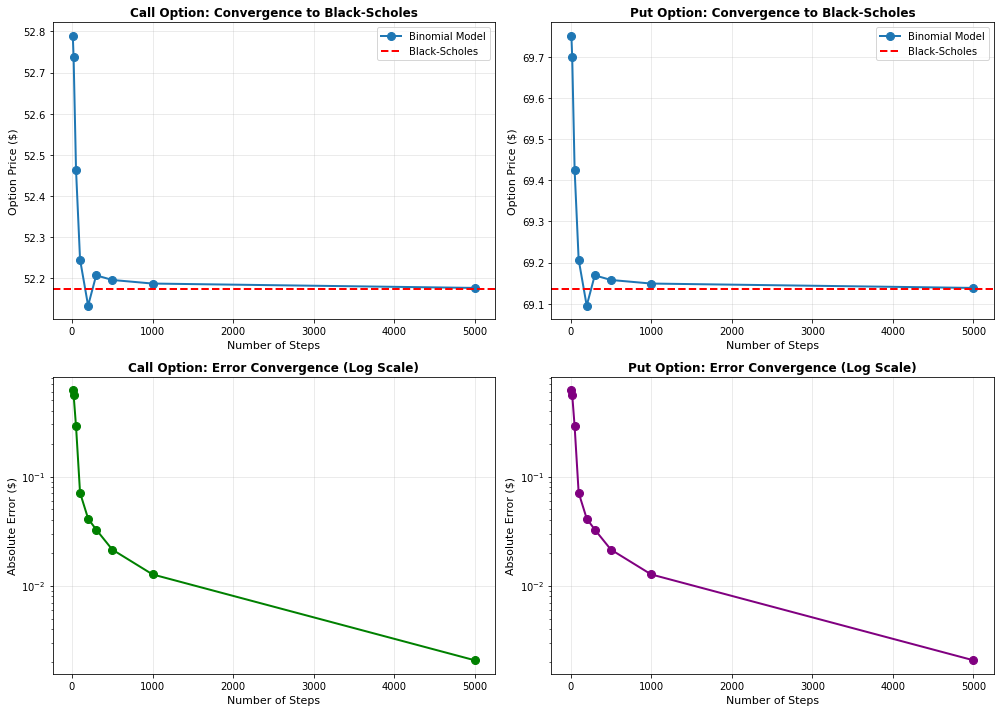

In [9]:
# Plot convergence
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Call option convergence
axes[0, 0].plot(step_sizes, binomial_prices_call, 'o-', label='Binomial Model', linewidth=2, markersize=8)
axes[0, 0].axhline(y=bs_price_call, color='r', linestyle='--', label='Black-Scholes', linewidth=2)
axes[0, 0].set_xlabel('Number of Steps', fontsize=11)
axes[0, 0].set_ylabel('Option Price ($)', fontsize=11)
axes[0, 0].set_title('Call Option: Convergence to Black-Scholes', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Put option convergence
axes[0, 1].plot(step_sizes, binomial_prices_put, 'o-', label='Binomial Model', linewidth=2, markersize=8)
axes[0, 1].axhline(y=bs_price_put, color='r', linestyle='--', label='Black-Scholes', linewidth=2)
axes[0, 1].set_xlabel('Number of Steps', fontsize=11)
axes[0, 1].set_ylabel('Option Price ($)', fontsize=11)
axes[0, 1].set_title('Put Option: Convergence to Black-Scholes', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Error convergence (Call)
axes[1, 0].semilogy(step_sizes, differences_call, 'o-', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Steps', fontsize=11)
axes[1, 0].set_ylabel('Absolute Error ($)', fontsize=11)
axes[1, 0].set_title('Call Option: Error Convergence (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Error convergence (Put)
axes[1, 1].semilogy(step_sizes, differences_put, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Steps', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error ($)', fontsize=11)
axes[1, 1].set_title('Put Option: Error Convergence (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Greeks Comparison: Binomial vs Black-Scholes


In [10]:
# Set up option parameters
S0 = current_price  # Current stock price
K = S0 * 1.05  # Strike price (5% out-of-the-money)
T = 0.25  # Time to expiration (3 months)
r = 0.05  # Risk-free rate (5%)
sigma = annual_volatility  # Volatility from historical data
n_steps = 1000  # Number of steps for binomial tree

# European Call
binomial_eu_call = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'call', 'european')
bs_call = BlackScholesPricer(S0, K, T, r, sigma, 'call')

# European Put
binomial_eu_put = BinomialOptionPricer(S0, K, T, r, sigma, n_steps, 'put', 'european')
bs_put = BlackScholesPricer(S0, K, T, r, sigma, 'put')

# Calculate Greeks for both models
binomial_greeks_call = binomial_eu_call.calculate_greeks()
bs_greeks_call = bs_call.calculate_greeks()

binomial_greeks_put = binomial_eu_put.calculate_greeks()
bs_greeks_put = bs_put.calculate_greeks()

print("GREEKS COMPARISON - CALL OPTION")
print(f"\n{'Greek':<15} {'Binomial':<15} {'Black-Scholes':<15} {'Difference':<15}")
for greek in ['Delta', 'Gamma', 'Theta', 'Vega']:
    bin_val = binomial_greeks_call[greek]
    bs_val = bs_greeks_call[greek]
    diff = abs(bin_val - bs_val)
    print(f"{greek:<15} {bin_val:<15.6f} {bs_val:<15.6f} {diff:<15.6f}")


print("\nGREEKS COMPARISON - PUT OPTION")
print(f"\n{'Greek':<15} {'Binomial':<15} {'Black-Scholes':<15} {'Difference':<15}")
for greek in ['Delta', 'Gamma', 'Theta', 'Vega']:
    bin_val = binomial_greeks_put[greek]
    bs_val = bs_greeks_put[greek]
    diff = abs(bin_val - bs_val)
    print(f"{greek:<15} {bin_val:<15.6f} {bs_val:<15.6f} {diff:<15.6f}")


GREEKS COMPARISON - CALL OPTION

Greek           Binomial        Black-Scholes   Difference     
Delta           0.519894        0.520166        0.000272       
Gamma           0.001233        0.002674        0.001441       
Theta           128.298358      -0.350888       128.649246     
Vega            91.317931       0.914323        90.403608      

GREEKS COMPARISON - PUT OPTION

Greek           Binomial        Black-Scholes   Difference     
Delta           -0.480106       -0.479834       0.000272       
Gamma           0.001233        0.002674        0.001441       
Theta           104.500646      -0.285693       104.786340     
Vega            91.317931       0.914323        90.403608      


## 7. Parameter Sensitivity Analysis


### 7.1 Greeks Sensitivity to Stock Price (S0)

Calculating Greeks for different stock prices...


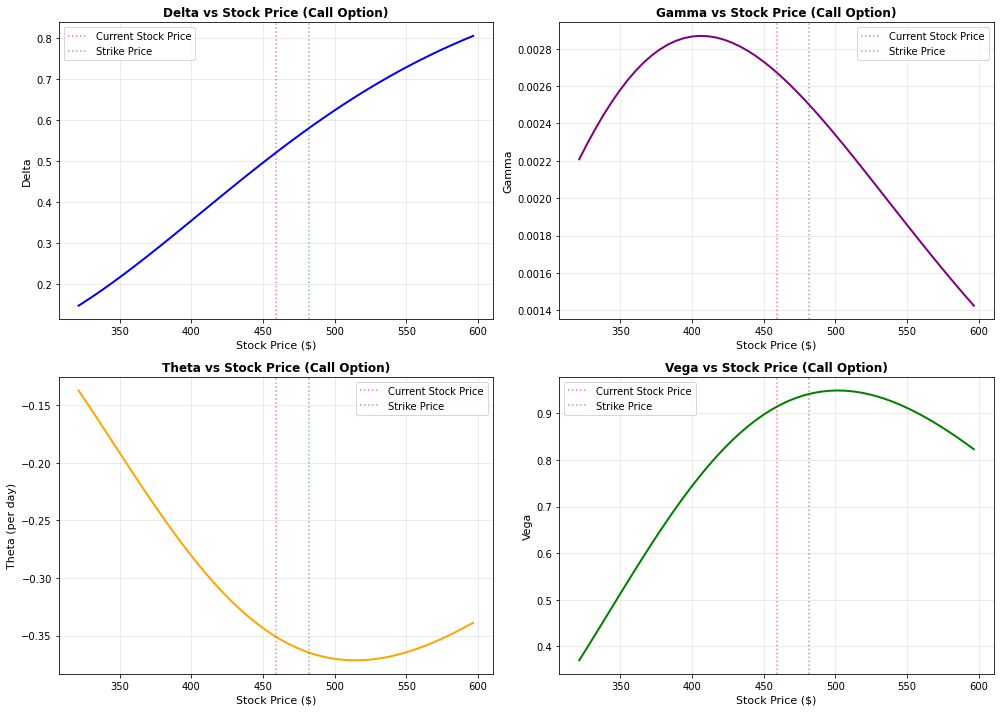

In [11]:
# Analyze how Greeks change with stock price (holding other parameters constant)
S_range = np.linspace(S0 * 0.7, S0 * 1.3, 50)
deltas_S = []
gammas_S = []
thetas_S = []
vegas_S = []

print("Calculating Greeks for different stock prices...")
for S in S_range:
    pricer = BlackScholesPricer(S, K, T, r, sigma, 'call')
    greeks = pricer.calculate_greeks()
    deltas_S.append(greeks['Delta'])
    gammas_S.append(greeks['Gamma'])
    thetas_S.append(greeks['Theta'])
    vegas_S.append(greeks['Vega'])

# Plot all Greeks vs Stock Price
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(S_range, deltas_S, linewidth=2, color='blue')
axes[0, 0].axvline(x=S0, color='r', linestyle=':', alpha=0.5, label='Current Stock Price')
axes[0, 0].axvline(x=K, color='g', linestyle=':', alpha=0.5, label='Strike Price')
axes[0, 0].set_xlabel('Stock Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Delta', fontsize=11)
axes[0, 0].set_title('Delta vs Stock Price (Call Option)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(S_range, gammas_S, linewidth=2, color='purple')
axes[0, 1].axvline(x=S0, color='r', linestyle=':', alpha=0.5, label='Current Stock Price')
axes[0, 1].axvline(x=K, color='g', linestyle=':', alpha=0.5, label='Strike Price')
axes[0, 1].set_xlabel('Stock Price ($)', fontsize=11)
axes[0, 1].set_ylabel('Gamma', fontsize=11)
axes[0, 1].set_title('Gamma vs Stock Price (Call Option)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(S_range, thetas_S, linewidth=2, color='orange')
axes[1, 0].axvline(x=S0, color='r', linestyle=':', alpha=0.5, label='Current Stock Price')
axes[1, 0].axvline(x=K, color='g', linestyle=':', alpha=0.5, label='Strike Price')
axes[1, 0].set_xlabel('Stock Price ($)', fontsize=11)
axes[1, 0].set_ylabel('Theta (per day)', fontsize=11)
axes[1, 0].set_title('Theta vs Stock Price (Call Option)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(S_range, vegas_S, linewidth=2, color='green')
axes[1, 1].axvline(x=S0, color='r', linestyle=':', alpha=0.5, label='Current Stock Price')
axes[1, 1].axvline(x=K, color='g', linestyle=':', alpha=0.5, label='Strike Price')
axes[1, 1].set_xlabel('Stock Price ($)', fontsize=11)
axes[1, 1].set_ylabel('Vega', fontsize=11)
axes[1, 1].set_title('Vega vs Stock Price (Call Option)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### 7.2 Greeks Sensitivity to Strike Price (K)

Calculating Greeks for different strike prices...


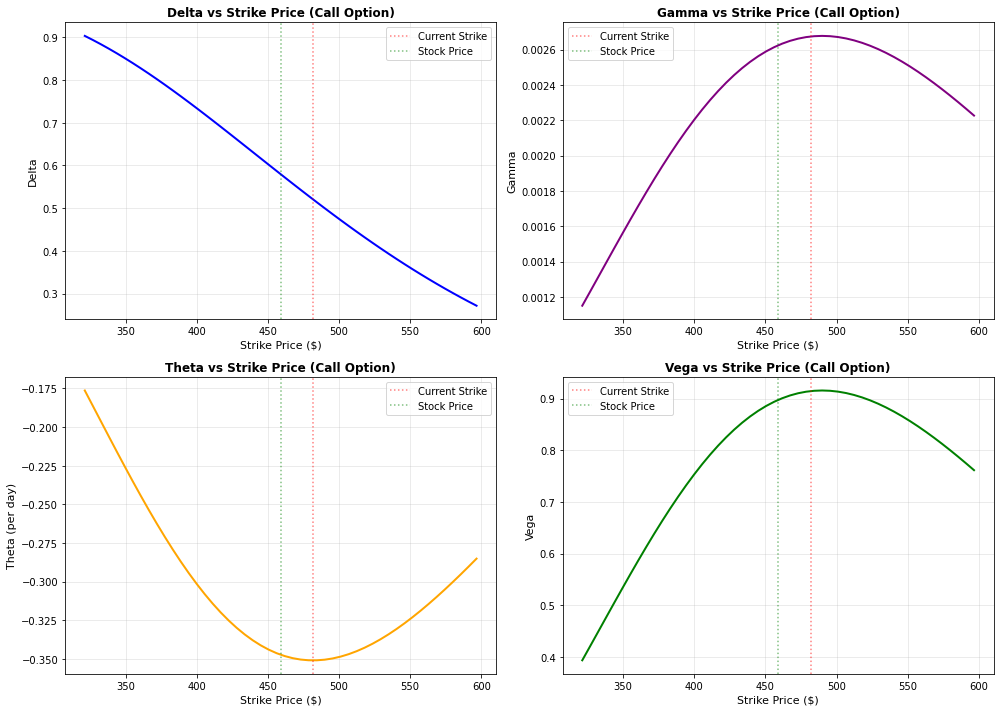

In [12]:
# Analyze how Greeks change with strike price (holding other parameters constant)
K_range = np.linspace(S0 * 0.7, S0 * 1.3, 50)
deltas_K = []
gammas_K = []
thetas_K = []
vegas_K = []

print("Calculating Greeks for different strike prices...")
for strike in K_range:
    pricer = BlackScholesPricer(S0, strike, T, r, sigma, 'call')
    greeks = pricer.calculate_greeks()
    deltas_K.append(greeks['Delta'])
    gammas_K.append(greeks['Gamma'])
    thetas_K.append(greeks['Theta'])
    vegas_K.append(greeks['Vega'])

# Plot all Greeks vs Strike Price
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(K_range, deltas_K, linewidth=2, color='blue')
axes[0, 0].axvline(x=K, color='r', linestyle=':', alpha=0.5, label='Current Strike')
axes[0, 0].axvline(x=S0, color='g', linestyle=':', alpha=0.5, label='Stock Price')
axes[0, 0].set_xlabel('Strike Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Delta', fontsize=11)
axes[0, 0].set_title('Delta vs Strike Price (Call Option)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(K_range, gammas_K, linewidth=2, color='purple')
axes[0, 1].axvline(x=K, color='r', linestyle=':', alpha=0.5, label='Current Strike')
axes[0, 1].axvline(x=S0, color='g', linestyle=':', alpha=0.5, label='Stock Price')
axes[0, 1].set_xlabel('Strike Price ($)', fontsize=11)
axes[0, 1].set_ylabel('Gamma', fontsize=11)
axes[0, 1].set_title('Gamma vs Strike Price (Call Option)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(K_range, thetas_K, linewidth=2, color='orange')
axes[1, 0].axvline(x=K, color='r', linestyle=':', alpha=0.5, label='Current Strike')
axes[1, 0].axvline(x=S0, color='g', linestyle=':', alpha=0.5, label='Stock Price')
axes[1, 0].set_xlabel('Strike Price ($)', fontsize=11)
axes[1, 0].set_ylabel('Theta (per day)', fontsize=11)
axes[1, 0].set_title('Theta vs Strike Price (Call Option)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(K_range, vegas_K, linewidth=2, color='green')
axes[1, 1].axvline(x=K, color='r', linestyle=':', alpha=0.5, label='Current Strike')
axes[1, 1].axvline(x=S0, color='g', linestyle=':', alpha=0.5, label='Stock Price')
axes[1, 1].set_xlabel('Strike Price ($)', fontsize=11)
axes[1, 1].set_ylabel('Vega', fontsize=11)
axes[1, 1].set_title('Vega vs Strike Price (Call Option)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### 7.3 Greeks Sensitivity to Time to Expiration (T)

Calculating Greeks for different times to expiration...


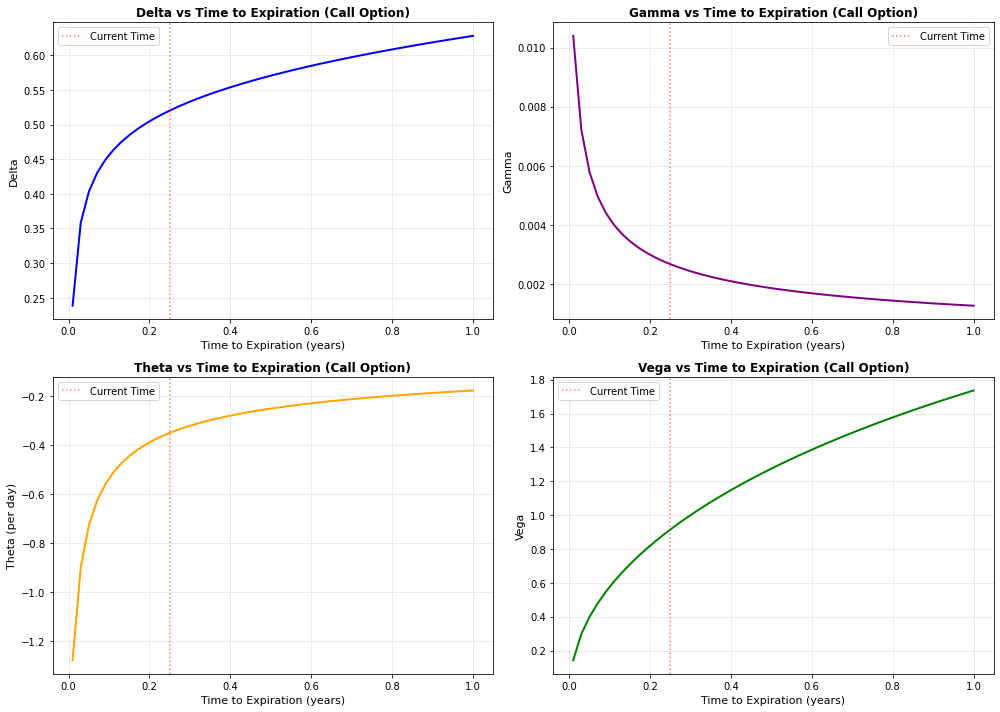

In [13]:
# Analyze how Greeks change with time to expiration (holding other parameters constant)
T_range = np.linspace(0.01, 1.0, 50)
deltas_T = []
gammas_T = []
thetas_T = []
vegas_T = []

print("Calculating Greeks for different times to expiration...")
for t in T_range:
    pricer = BlackScholesPricer(S0, K, t, r, sigma, 'call')
    greeks = pricer.calculate_greeks()
    deltas_T.append(greeks['Delta'])
    gammas_T.append(greeks['Gamma'])
    thetas_T.append(greeks['Theta'])
    vegas_T.append(greeks['Vega'])

# Plot all Greeks vs Time to Expiration
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(T_range, deltas_T, linewidth=2, color='blue')
axes[0, 0].axvline(x=T, color='r', linestyle=':', alpha=0.5, label='Current Time')
axes[0, 0].set_xlabel('Time to Expiration (years)', fontsize=11)
axes[0, 0].set_ylabel('Delta', fontsize=11)
axes[0, 0].set_title('Delta vs Time to Expiration (Call Option)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(T_range, gammas_T, linewidth=2, color='purple')
axes[0, 1].axvline(x=T, color='r', linestyle=':', alpha=0.5, label='Current Time')
axes[0, 1].set_xlabel('Time to Expiration (years)', fontsize=11)
axes[0, 1].set_ylabel('Gamma', fontsize=11)
axes[0, 1].set_title('Gamma vs Time to Expiration (Call Option)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(T_range, thetas_T, linewidth=2, color='orange')
axes[1, 0].axvline(x=T, color='r', linestyle=':', alpha=0.5, label='Current Time')
axes[1, 0].set_xlabel('Time to Expiration (years)', fontsize=11)
axes[1, 0].set_ylabel('Theta (per day)', fontsize=11)
axes[1, 0].set_title('Theta vs Time to Expiration (Call Option)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(T_range, vegas_T, linewidth=2, color='green')
axes[1, 1].axvline(x=T, color='r', linestyle=':', alpha=0.5, label='Current Time')
axes[1, 1].set_xlabel('Time to Expiration (years)', fontsize=11)
axes[1, 1].set_ylabel('Vega', fontsize=11)
axes[1, 1].set_title('Vega vs Time to Expiration (Call Option)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 7.4 Greeks Sensitivity to Volatility (σ)


Calculating Greeks for different volatilities...


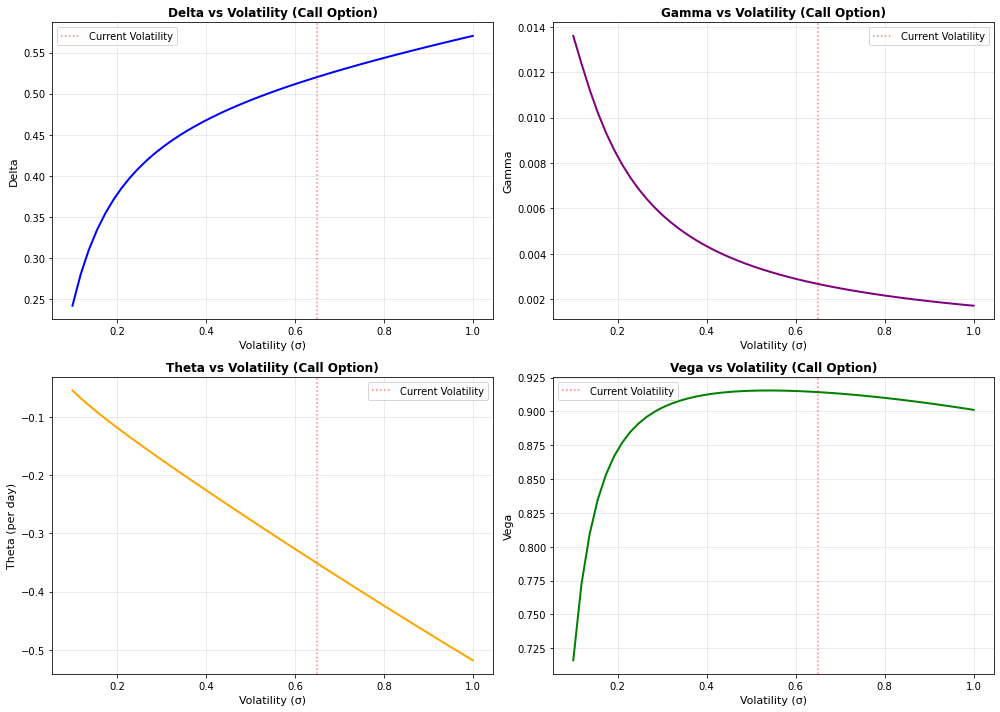

In [14]:
# Analyze how Greeks change with volatility (holding other parameters constant)
vol_range = np.linspace(0.1, 1.0, 50)
deltas_vol = []
gammas_vol = []
thetas_vol = []
vegas_vol = []

print("Calculating Greeks for different volatilities...")
for vol in vol_range:
    pricer = BlackScholesPricer(S0, K, T, r, vol, 'call')
    greeks = pricer.calculate_greeks()
    deltas_vol.append(greeks['Delta'])
    gammas_vol.append(greeks['Gamma'])
    thetas_vol.append(greeks['Theta'])
    vegas_vol.append(greeks['Vega'])

# Plot all Greeks vs Volatility
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(vol_range, deltas_vol, linewidth=2, color='blue')
axes[0, 0].axvline(x=sigma, color='r', linestyle=':', alpha=0.5, label='Current Volatility')
axes[0, 0].set_xlabel('Volatility (σ)', fontsize=11)
axes[0, 0].set_ylabel('Delta', fontsize=11)
axes[0, 0].set_title('Delta vs Volatility (Call Option)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(vol_range, gammas_vol, linewidth=2, color='purple')
axes[0, 1].axvline(x=sigma, color='r', linestyle=':', alpha=0.5, label='Current Volatility')
axes[0, 1].set_xlabel('Volatility (σ)', fontsize=11)
axes[0, 1].set_ylabel('Gamma', fontsize=11)
axes[0, 1].set_title('Gamma vs Volatility (Call Option)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(vol_range, thetas_vol, linewidth=2, color='orange')
axes[1, 0].axvline(x=sigma, color='r', linestyle=':', alpha=0.5, label='Current Volatility')
axes[1, 0].set_xlabel('Volatility (σ)', fontsize=11)
axes[1, 0].set_ylabel('Theta (per day)', fontsize=11)
axes[1, 0].set_title('Theta vs Volatility (Call Option)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(vol_range, vegas_vol, linewidth=2, color='green')
axes[1, 1].axvline(x=sigma, color='r', linestyle=':', alpha=0.5, label='Current Volatility')
axes[1, 1].set_xlabel('Volatility (σ)', fontsize=11)
axes[1, 1].set_ylabel('Vega', fontsize=11)
axes[1, 1].set_title('Vega vs Volatility (Call Option)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




### 7.5 Greeks Sensitivity to Risk-free Rate (r)

Calculating Greeks for different risk-free rates...


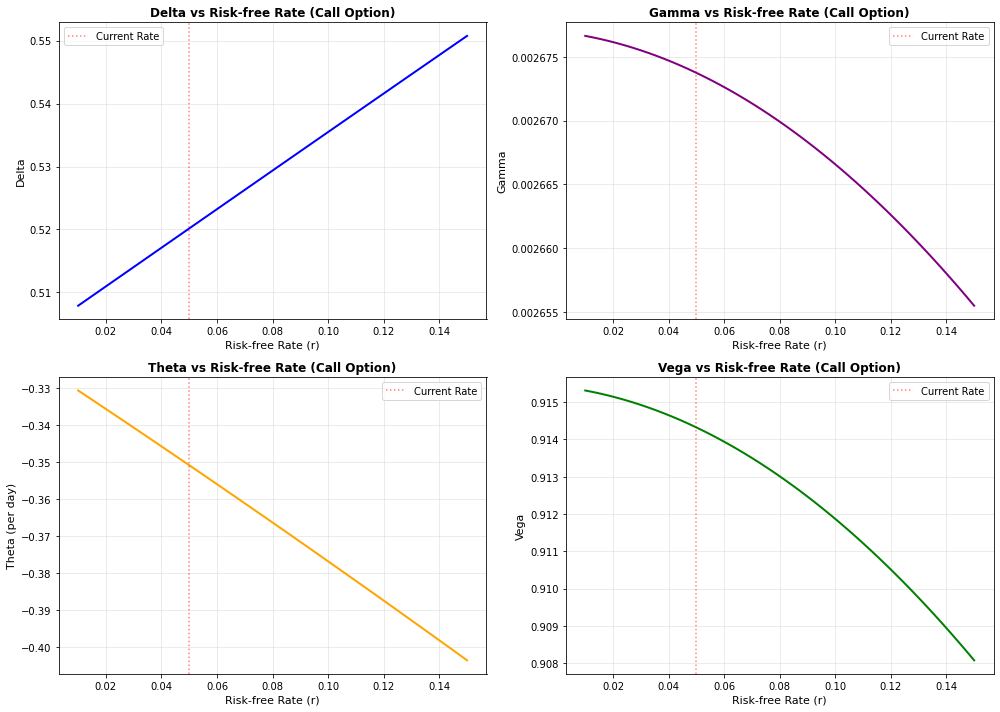

In [15]:
# Analyze how Greeks change with risk-free rate (holding other parameters constant)
r_range = np.linspace(0.01, 0.15, 50)
deltas_r = []
gammas_r = []
thetas_r = []
vegas_r = []

print("Calculating Greeks for different risk-free rates...")
for rate in r_range:
    pricer = BlackScholesPricer(S0, K, T, rate, sigma, 'call')
    greeks = pricer.calculate_greeks()
    deltas_r.append(greeks['Delta'])
    gammas_r.append(greeks['Gamma'])
    thetas_r.append(greeks['Theta'])
    vegas_r.append(greeks['Vega'])

# Plot all Greeks vs Risk-free Rate
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(r_range, deltas_r, linewidth=2, color='blue')
axes[0, 0].axvline(x=r, color='r', linestyle=':', alpha=0.5, label='Current Rate')
axes[0, 0].set_xlabel('Risk-free Rate (r)', fontsize=11)
axes[0, 0].set_ylabel('Delta', fontsize=11)
axes[0, 0].set_title('Delta vs Risk-free Rate (Call Option)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(r_range, gammas_r, linewidth=2, color='purple')
axes[0, 1].axvline(x=r, color='r', linestyle=':', alpha=0.5, label='Current Rate')
axes[0, 1].set_xlabel('Risk-free Rate (r)', fontsize=11)
axes[0, 1].set_ylabel('Gamma', fontsize=11)
axes[0, 1].set_title('Gamma vs Risk-free Rate (Call Option)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(r_range, thetas_r, linewidth=2, color='orange')
axes[1, 0].axvline(x=r, color='r', linestyle=':', alpha=0.5, label='Current Rate')
axes[1, 0].set_xlabel('Risk-free Rate (r)', fontsize=11)
axes[1, 0].set_ylabel('Theta (per day)', fontsize=11)
axes[1, 0].set_title('Theta vs Risk-free Rate (Call Option)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(r_range, vegas_r, linewidth=2, color='green')
axes[1, 1].axvline(x=r, color='r', linestyle=':', alpha=0.5, label='Current Rate')
axes[1, 1].set_xlabel('Risk-free Rate (r)', fontsize=11)
axes[1, 1].set_ylabel('Vega', fontsize=11)
axes[1, 1].set_title('Vega vs Risk-free Rate (Call Option)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
